<a href="https://colab.research.google.com/github/AutoResearch/EEG-GAN/blob/3-release-as-pip-package/docs/Tutorials/Tutorial_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Augmenting EEG with Generative Adversarial Networks<br>

*Created by Daniel Weinhardt, Chad Williams, & Sebastian Musslick*

---
---

We here use Generative Adversarial Networks (GANs) to create trial-level synthetic EEG samples. We can then use these samples as extra data to train whichever classifier we want to use (e.g.,  Support Vector Machine, Neural Network).

GANs are machine learning frameworks that consist of two adversarial neural network agents, namely the generator and the discriminator. The generator is trained to create novel samples that are indiscernible from real samples. In the current context, the generator produces realistic continuous EEG activity, conditioned on a set of experimental variables, which contain underlying neural features representative of the outcomes being classified. For example, depression manifests as increased alpha oscillatory activity in the EEG signal, and thus, an ideal generator would produce continuous EEG that includes these alpha signatures. In contrast to the generator, the discriminator determines whether a given sample is real or synthetically produced by the generator. The core insight of GANs is that the generator can effectively learn from the discriminator. Specifically, the generator will consecutively produce more realistic synthetic samples with the goal of “fooling” the discriminator into believing them as real. Once it has achieved realistic samples that the discriminator cannot discern, it can be used to generate synthetic data—or in this context, synthetic EEG data.

The dataset provided is a subset of data from Williams et al., 2021 (*Psychophysics*). In this study, participants completed a two-armed bandit gambling task where they needed to discern which of two coloured squares were more often rewarding through trial-and-error. Each trial presented two coloured squares that the participants were to choose from, and provided performance feedback as “WIN” or “LOSE”, yielding two conditions of interest, cwin, close. For each pair of squares, one had a win rate of 60% while the other had a win rate of 10%. Participants saw each pair of colours twenty times consecutively. There were a total of five pairs of squares (with colours randomly determined), resulting in one hundred trials per participant. This paradigm elicits well-known frontal neural differences when contrasting the win and lose outcomes, namely in the reward positivity, delta oscillations, and theta oscillations (see Williams et al., 2021; Psychophysics).

In this tutorial, we will classify the WIN and LOSE conditions using both Support Vector Machine and Neural Network classifiers. We will:
1. Train a GAN on trial-level EEG data
2. Generate synthetic EEG data
3. Create an augmented EEG dataset
4. Determine classification performance using both the empirical and augmented datasets
    - Empirical Dataset: We train the classifer on the empirical data that was used to train the GANs
    - Augmented Dataset: We train the classifer on the empirical data with the appended synthetic samples

---
---
## Evaluation of EEG-GAN
**Augmenting EEG with Generative Adversarial Networks Enhances Brain Decoding Across Classifiers and Sample Sizes**<br>
$Williams^{*1}$, $Weinhardt^{*2}$, $Wirzberger^{2}$, & $Musslick^{1}$ (*submitted, 2023*)<br>
**Co-First Authors*<br>
$^{1}$ *Brainstorm, Carney Institute for Brain Science, Brown University*<br>
$^{2}$ *University of Stuttgart* <br>

---
---
## Table of Contents
    Step 0. Installing and Loading Modules
        Step 0.1. Installing Modules
        Step 0.2. Loading Modules
    Step 1. EEG Data
        Step 1.1. Load Data
        Step 1.2. View Data
    Step 2. GAN
        Step 2.1. Exploring the Main GAN Package Functions
            Step 2.1.1. GAN Training Help
            Step 2.1.2. Visualize Help
            Step 2.1.3. Generate Samples Help
        Step 2.2. Training the GAN
        Step 2.3. Visualizing GAN Losses
        Step 2.4. Generating Synthetic Data
    Step 3. Synthetic Data
        Step 3.1. Load Data
        Step 3.2. View Data
            Step 3.2.1. View Trial-Level Data
            Step 3.2.2. View ERP Data
    Step 4. Classification Setup
        Step 4.1. Preparing Validation Data
        Step 4.2. Preparing Empirical Data
        Step 4.3. Preparing Augmented Data
    Step 5. Support Vector Machine
        Step 5.1. Define Search Space
        Step 5.2. Classify Empirical Data
        Step 5.3. Classify Augmented Data
    Step 6. Neural Network
        Step 6.1. Define Search Space
        Step 6.2. Classify Empirical Data
        Step 6.3. Classify Augmented Data
    Step 7. Final Report
        Step 7.1. Present Classification Performance
        Step 7.2. Plot Classification Performance

*Note: you can also view an interactive table of contents in your sidebar*

# Step 0. Installing and Loading Modules

## Step 0.1. Installing Modules
We will now download and install the EEG-GAN package


In [1]:
%%capture

#Pull Repo
!git clone -b dev https://github.com/AutoResearch/EEG-GAN.git --single-branch

#Install Requirements
!pip3 install torch torchvision torchaudio torchsummary
!pip install pandas==1.3.4
!pip install numpy==1.21.4
!pip install matplotlib==3.5.0
!pip install scipy==1.8.0
!pip install einops==0.4.1
!pip install scikit-learn==1.1.2
!pip install tqdm

# Step 0.2. Loading Modules

In [2]:
#Load other modules specific to this notebook
import numpy as np
import matplotlib.pyplot as plt
import shutil
import os
import random as rnd
from scipy import signal
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
import torch

#Create a print formatting class
class printFormat:
    bold = '\033[1m'
    italic = '\033[3m'
    end = '\033[0m'

/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Step 1. EEG Data

## Step 1.1. Load Data
We will load the provided EEG training data and print some information about what this contains.

In [3]:
#Load the data
empiricalHeaders = np.genfromtxt('EEG-GAN/data/gansEEGTrainingData.csv', delimiter=',', names=True).dtype.names
empiricalEEG = np.genfromtxt('EEG-GAN/data/gansEEGTrainingData.csv', delimiter=',', skip_header=1)

#Print the head of the data
print(printFormat.bold + 'Display Header and first few rows/columns of data\n \033[0m' + printFormat.end)
print(empiricalHeaders[:6])
print(empiricalEEG[0:3,:6])

#Print some information about the columns
print('\n------------------------------------------------------------------------------------------')
print(printFormat.bold + '\nNote the first three columns:' + printFormat.end +'\n    ParticipantID - Indicates different participants\n    Condition - Indicates the condition (WIN = 0, LOSE = 1) to be classified\n    Trial - Indicates the trial number for that participant and condition')
print('\nThe remaining columns are titled Time1 to Time100 - indicating 100 datapoints per sample.\nThe samples span from -200 to 1000ms around the onset of a feedback stimulus.\nThese are downsampled from the original data, which contained 600 datapoints per sample.')

#Print some meta-data
print('\n------------------------------------------------------------------------------------------')
print('\n' + printFormat.bold + 'Other characteristics of our data include:' + printFormat.end)
print('-We have ' + str(len(set(empiricalEEG[:,0]))) + ' participants in our training set')
print('-Participants have an average of ' + str(round(np.mean([np.max(empiricalEEG[empiricalEEG[:,0]==pID,2]) for pID in set(empiricalEEG[:,0])]))) + ' (SD: ' + str(round(np.std([np.max(empiricalEEG[empiricalEEG[:,0]==pID,2]) for pID in set(empiricalEEG[:,0])]))) + ')' + ' trials per outcome (win, lose)')

Display Header and first few rows/columns of data
 
('ParticipantID', 'Condition', 'Trial', 'Time1', 'Time2', 'Time3')
[[11.        0.        1.        2.287618 -4.448947 -0.980726]
 [11.        0.        2.       11.672745  0.669828  1.43829 ]
 [11.        0.        3.       10.510648 11.908067  8.671387]]

------------------------------------------------------------------------------------------

Note the first three columns:
    ParticipantID - Indicates different participants
    Condition - Indicates the condition (WIN = 0, LOSE = 1) to be classified
    Trial - Indicates the trial number for that participant and condition

The remaining columns are titled Time1 to Time100 - indicating 100 datapoints per sample.
The samples span from -200 to 1000ms around the onset of a feedback stimulus.
These are downsampled from the original data, which contained 600 datapoints per sample.

------------------------------------------------------------------------------------------

Other charact

## Step 1.2. View Data
Let's view the grand-averaged ERPs of our 15 participants.

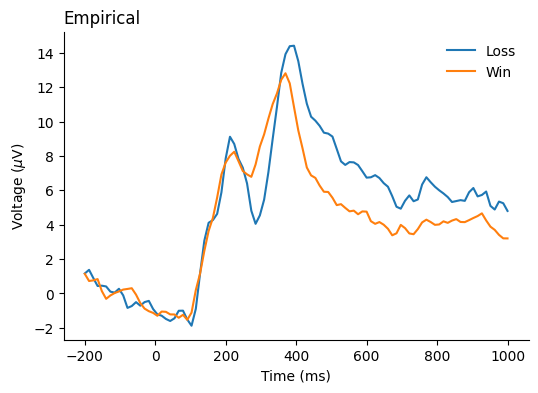

In [4]:
#Determine which rows are each condition
lossIndex = np.where(empiricalEEG[:,1]==1)
winIndex = np.where(empiricalEEG[:,1]==0)

#Grand average the waveforms for each condition
lossWaveform = np.mean(empiricalEEG[lossIndex,3:],axis=1)[0]
winWaveform = np.mean(empiricalEEG[winIndex,3:],axis=1)[0]

#Determine x axis of time
time = np.linspace(-200,1000,100)

#Setup figure
f, (ax1) = plt.subplots(1, 1, figsize=(6, 4))

#Plot each waveform
ax1.plot(time, lossWaveform, label = 'Loss')
ax1.plot(time, winWaveform, label = 'Win')

#Format plot
ax1.set_ylabel('Voltage ($\mu$V)')
ax1.set_xlabel('Time (ms)')
ax1.set_title('Empirical', loc='left')
ax1.spines[['right', 'top']].set_visible(False)
ax1.legend(frameon=False)

# Step 2. GAN

## Step 2.1. Exploring the Main GAN Package Functions
<br><b>Functions</b><br>
We will be using three functions from the GANs package:<br>
&emsp;&emsp;```train_gan()``` - This trains a GAN <br>
&emsp;&emsp;```visualize_gan()``` - This visualizes components of a trained GAN, such as the training losses <br>
&emsp;&emsp;```generate_samples()``` - This generates synthetic samples using the trained GAN<br>

<br><b>Arguments</b><br>

Each function can take a single argument ```argv```, which should be a dictionary:<br>

&emsp;&emsp;```argv = dict(```<br>
&emsp;&emsp;&emsp;```path_dataset=data\my_data.csv,```<br>
&emsp;&emsp;&emsp;```n_epochs = 100```<br>
&emsp;&emsp;```)```<br>

&emsp;&emsp;```train_gan(argv)```

<br><b>Help</b><br>

You can use the help argument to see a list of possible arguments with a brief description:</b><br>
&emsp;&emsp;```train_gan(dict(help = True))```<br>
&emsp;&emsp;```visualize_gan(dict(help = True))```<br>
&emsp;&emsp;```generate_samples(dict(help = True))```<br>

### Step 2.1.1. GAN Training Help

In [5]:
!python EEG-GAN/gan_training_main.py help

Directory "../trained_models" created to store checkpoints and final model.

-----------------------------------------
Command line arguments:
-----------------------------------------



----------------------------------------------------------------------------------------------------------------------------------------------------
INPUT HELP - These are the inputs that can be given from the command line
----------------------------------------------------------------------------------------------------------------------------------------------------


Input            | Type            | Description                                                                              | Default value               
----------------------------------------------------------------------------------------------------------------------------------------------------
ddp              | <class 'bool'>  | Activate distributed training                                                            | Fals

### Step 2.1.2. Visualize Help

In [6]:
!python EEG-GAN/visualize_main.py help


-----------------------------------------
Command line arguments:
-----------------------------------------



----------------------------------------------------------------------------------------------------------------------------------------------------
INPUT HELP - These are the inputs that can be given from the command line
----------------------------------------------------------------------------------------------------------------------------------------------------


Input           | Type           | Description                                                                              | Default value         
----------------------------------------------------------------------------------------------------------------------------------------------------
loss            | <class 'bool'> | Plot training loss                                                                       | False                 
average         | <class 'bool'> | Average over all samples to get 

### Step 2.1.3. Generate Samples Help

In [7]:
!python EEG-GAN/generate_samples_main.py help


-----------------------------------------
Command line arguments:
-----------------------------------------



----------------------------------------------------------------------------------------------------------------------------------------------------
INPUT HELP - These are the inputs that can be given from the command line
----------------------------------------------------------------------------------------------------------------------------------------------------


Input                | Type           | Description                                                                                  | Default value               
----------------------------------------------------------------------------------------------------------------------------------------------------
seed                 | <class 'bool'> | Set seed for reproducibility                                                                 | False                       
model                | <class 'str'> 

## Step 2.2. Training the GAN

To train the GAN in this tutorial, we will be using the following arguments:
- <b>path_dataset=data/gansEEGTrainingData.csv</b> : Determines the training dataset
- <b>n_epochs=5</b> : Determines number of times to train the GAN<br>
&emsp;&emsp;-*Here we only use 5 epochs to demonstrate the process but this will result in a very under-trained GAN. In the manuscript, we trained for 8000 epochs.*

*Note: If the **ddp** argument is provided, GANs will be trained using GPUs rather than CPUs*

In [8]:
#Train the GAN on CPUs
# !python EEG-GAN/vae_training_main.py ddp=False data="data/gansEEGTrainingData.csv" n_epochs=10

# Train the VAE on GPUs
!python EEG-GAN/gan_training_main.py ddp=True data="EEG-GAN/data/gansEEGTrainingData.csv" n_epochs=100
# Note, on Google Colab you can start a GPU runtime by going to Runtime > Change runtime type > Hardware accelerator > GPU


-----------------------------------------
Command line arguments:
-----------------------------------------

Distributed training is activeTrue
Dataset: EEG-GAN/data/gansEEGTrainingData.csv
Number of epochs: 100
Generator and discriminator initialized.

-----------------------------------------
Training GAN...
-----------------------------------------

Using device cuda:0.
100% 100/100 [01:11<00:00,  1.40it/s, D LOSS: 3.916223, G LOSS: -0.780727]
Managing checkpoints...
Checkpoint saved to trained_models/checkpoint.pt.
Training complete in: 00:01:15
Model training finished.
Model states and generated samples saved to file trained_models/gan_ddp_100ep_20240524_212322.pt.
GAN training finished.


# Step 2.3. Visualizing GAN Losses

The GAN trains for the number of epochs specified above; however, this does not ensure that it will train successfully. So, it is important to visualize our training success and ensure that it completed successfully. If it did, we can move forward with using the GAN, but if it did not then we would need to continue training the GAN. This latter case is not a problem though because the package was built so that you can continue training a previously trained GAN (rather than having to start over) if you use the ```load_checkpoint``` and ```path_checkpoint``` arguments with the ```train_gan.py``` function.  

We will now visualize the generator and discriminator losses using the following arguments:
- <b>plot_losses</b> : Determines that we will be viewing the losses
- <b>checkpoint </b> : Specifies that we are visualizing a GAN
- <b>file=ganEEGModel.pt</b> : Determines which GAN to visualize
- <b>training_file=data\gansEEGTrainingData.csv</b> : Points towards the data used to train the GAN

We will know that training was successful if both the generator and discriminator losses hover around 0 at the end of training.

In [9]:
!python EEG-GAN/visualize_main.py loss=True model="EEG-GAN/trained_models/gansEEGModel.pt"


-----------------------------------------
Command line arguments:
-----------------------------------------

Plotting training lossTrue
Using samples from model/checkpoint file (.pt)EEG-GAN/trained_models/gansEEGModel.pt

-----------------------------------------
System output:
-----------------------------------------

Traceback (most recent call last):
  File "/content/EEG-GAN/visualize_main.py", line 292, in <module>
    main()
  File "/content/EEG-GAN/visualize_main.py", line 62, in main
    data = np.concatenate(state_dict['samples'])
KeyError: 'samples'


## Step 2.4. Generating Synthetic Data

We will be using the following arguments:
- <b> file=gansEEGModel.pt </b> : Determines which model to use<br>
&emsp;&emsp;*The default trained GAN name is checkpoint.pt but we will instead use a pre-trained GAN named gansEEGModel.pt*
- <b> path_samples=gansEEGSyntheticData.csv </b> : Where and what to save the generated samples as
- <b> num_samples_total=10000 </b> : Number of samples to generate (half per condition)

In [14]:
#We trained our GAN for 5 epochs and this will result in a model that is severally under-trained, so we will instead use a pre-trained GAN that trained for 8000 epochs:

!python EEG-GAN/generate_samples_main.py model="EEG-GAN/trained_models/gansEEGModel.pt" save_name="EEG-GAN/generated_samples/gansEEGSyntheticData.csv" num_samples_total=10000

#The GAN training results fom the last step results in a file named checkpoint.pt. If you want to continue with this file, use the following line of code:

!python EEG-GAN/generate_samples_main.py model="checkpoint.pt" save_name="EEG-GAN/generated_samples/gansEEGSyntheticData.csv" num_samples_total=10000


-----------------------------------------
Command line arguments:
-----------------------------------------

File: EEG-GAN/trained_models/gansEEGModel.pt
Saving generated samples to file: EEG-GAN/generated_samples/gansEEGSyntheticData.csv
Total number of generated samples: 10000

-----------------------------------------
System output:
-----------------------------------------

Traceback (most recent call last):
  File "/content/EEG-GAN/generate_samples_main.py", line 244, in <module>
    main()
  File "/content/EEG-GAN/generate_samples_main.py", line 63, in main
    n_conditions = len(state_dict['configuration']['kw_conditions']) if state_dict['configuration']['kw_conditions'] and state_dict['configuration']['kw_conditions'] != [''] else 0
KeyError: 'kw_conditions'

-----------------------------------------
Command line arguments:
-----------------------------------------

File: checkpoint.pt
Saving generated samples to file: EEG-GAN/generated_samples/gansEEGSyntheticData.csv
Total n

# Step 3. Synthetic Data

## Step 3.1. Load Data
We will now load the synthetic data we just produced, and confirm the number of samples per condition

In [15]:
#Load Data
syntheticEEG = np.genfromtxt('EEG-GAN/generated_samples/gansEEGSyntheticData.csv', delimiter=',', skip_header=1)

#Print head of the data
print(printFormat.bold + 'Display first few rows/columns of data' + printFormat.end)
print(['Condition','Time1','Time2','Time3','Time4','Time5'])
print(syntheticEEG[0:3,0:6])

#Print condition sample counts
print('\n' + printFormat.bold + 'Display trial counts for each condition' + printFormat.end)
print(printFormat.bold +'Win: ' + printFormat.end + str(np.sum(syntheticEEG[:,0]==0)))
print(printFormat.bold +'Lose: ' + printFormat.end + str(np.sum(syntheticEEG[:,0]==1)))

Display first few rows/columns of data
['Condition', 'Time1', 'Time2', 'Time3', 'Time4', 'Time5']
[[0.         0.66762149 0.29018313 0.70145869 0.61749375 0.30328485]
 [0.         0.64910698 0.31019881 0.11871838 0.39631823 0.7448132 ]
 [0.         0.11846031 0.79338944 0.26544994 0.98173702 0.3072094 ]]

Display trial counts for each condition
Win: 10000
Lose: 0


## Step 3.2. View Data

### Step 3.2.1. View Trial-Level Data
We will view 5 trial level data for both the empirical and synthetic data.

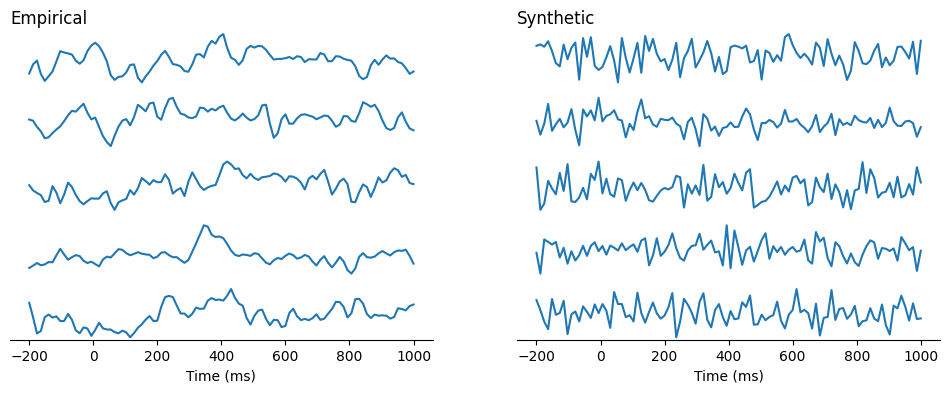

In [16]:
#Determine 5 random trials to plot
empiricalIndex = rnd.sample(range(0, empiricalEEG.shape[0]), 5)
syntheticIndex = rnd.sample(range(0, syntheticEEG.shape[0]), 5)

#Plot trial data
f, ax = plt.subplots(5, 2, figsize=(12, 4))
for c in range(5):
    ax[c,0].plot(time,empiricalEEG[empiricalIndex[c],3:]) #Note, we here add the same filter simply for visualization
    ax[c,0].set_yticks([])

    ax[c,1].plot(time,syntheticEEG[syntheticIndex[c],1:])
    ax[c,1].spines[['left', 'right', 'top']].set_visible(False)
    ax[c,1].set_yticks([])

    if c == 0:
        ax[c,0].set_title('Empirical', loc='left')
        ax[c,1].set_title('Synthetic', loc='left')
    else:
        ax[c,0].set_title(' ')
        ax[c,1].set_title(' ')

    if c != 4:
        ax[c,0].spines[['bottom', 'left', 'right', 'top']].set_visible(False)
        ax[c,1].spines[['bottom', 'left', 'right', 'top']].set_visible(False)
        ax[c,0].set_xticks([])
        ax[c,1].set_xticks([])
    else:
        ax[c,0].spines[['left', 'right', 'top']].set_visible(False)
        ax[c,1].spines[['left', 'right', 'top']].set_visible(False)
        ax[c,0].set_xlabel('Time (ms)')
        ax[c,1].set_xlabel('Time (ms)')

## Step 3.2.2. View ERP Data
We will now show the empirical and synthetic ERPs side-by-side for comparison.

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  otherwise return a reference to the output array.
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  stacklevel=2
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:224: RuntimeWarning: Mean of empty slice
  mean_ = np.nanmean(X, axis)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:232: RuntimeWarning: Mean of empty slice
  mean_1 = np.nanmean(Xr, axis=0)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/usr/local/lib/python3.10/

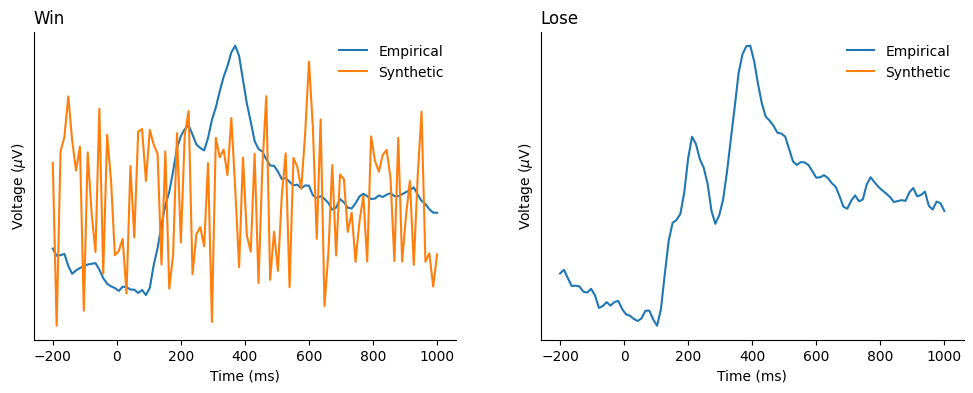

In [17]:
#Grand average the synthetic waveforms for each condition
synLossWaveform = np.mean(syntheticEEG[np.r_[syntheticEEG[:,0]==1],1:],axis=0)
synWinWaveform = np.mean(syntheticEEG[np.r_[syntheticEEG[:,0]==0],1:],axis=0)

#Set up figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

#Plot each empirical waveform (note, we here add the same processing simply for visualization)
ax1.plot(time, scale(winWaveform), label = 'Empirical')
ax1.plot(time, scale(synWinWaveform), label = 'Synthetic')

#Format plot
ax1.set_ylabel('Voltage ($\mu$V)')
ax1.set_xlabel('Time (ms)')
ax1.set_title('Win', loc='left')
ax1.spines[['right', 'top']].set_visible(False)
ax1.tick_params(left = False, labelleft = False)
ax1.legend(frameon=False)

#Plot each synthetic waveform
ax2.plot(time, scale(lossWaveform), label = 'Empirical')
ax2.plot(time, scale(synLossWaveform), label = 'Synthetic')

#Format plot
ax2.set_ylabel('Voltage ($\mu$V)')
ax2.set_xlabel('Time (ms)')
ax2.set_title('Lose', loc='left')
ax2.spines[['right', 'top']].set_visible(False)
ax2.tick_params(left = False, labelleft = False)
ax2.legend(frameon=False)

# Step 4. Classification

## Step 4.1. Preparing Validation Data
We also provide a validation dataset with samples not contained in the empirical dataset. Here, we prepare them for classification.

In [18]:
#Set seed for a bit of reproducibility
rnd.seed(1618)

#This function averages trial-level empirical data for each participant and condition
def averageEEG(EEG):
    participants = np.unique(EEG[:,0])
    averagedEEG = []
    for participant in participants:
        for condition in range(2):
            averagedEEG.append(np.mean(EEG[(EEG[:,0]==participant)&(EEG[:,1]==condition),:], axis=0))
    return np.array(averagedEEG)

#Load test data to predict (data that neither the GAN nor the classifier will ever see in training)
EEGDataTest = np.genfromtxt('EEG-GAN/data/gansEEGValidationData.csv', delimiter=',', skip_header=1)
EEGDataTest = averageEEG(EEGDataTest)[:,1:]

#Extract test outcome and predictor data
y_test = EEGDataTest[:,0]
x_test = EEGDataTest[:,2:]
x_test = scale(x_test,axis = 1)

## Step 4.2. Preparing Empirical Data
We now prepare the empirical training set. Our predictors will be the entire time series of 100 datapoints, however, in the manuscript we also ran parallel classifications with three extracted EEG features.

In [19]:
#Create participant by condition averages
Emp_train = averageEEG(empiricalEEG)[:,1:]

#Extract the outcomes
Emp_Y_train = Emp_train[:,0]

#Scale the predictors
Emp_X_train = scale(Emp_train[:,2:], axis=1)

#Shuffle the order of samples
trainShuffle = rnd.sample(range(len(Emp_X_train)),len(Emp_X_train))
Emp_Y_train = Emp_Y_train[trainShuffle]
Emp_X_train = Emp_X_train[trainShuffle,:]

## Step 4.3. Preparing Augmented Data
We will prepare the augmented dataset by first processing the synthetic data as we did with the empirical data, then combining both the empirical and synthetic dataset to create an augmented dataset.

In [20]:
#This function averages trial-level synthetic data in bundles of 50 trials, constrained to each condition
def averageSynthetic(synData):
    samplesToAverage = 50

    lossSynData = synData[synData[:,0]==0,:]
    winSynData = synData[synData[:,0]==1,:]

    lossTimeIndices = np.arange(0,lossSynData.shape[0],samplesToAverage)
    winTimeIndices = np.arange(0,winSynData.shape[0],samplesToAverage)

    newLossSynData = [np.insert(np.mean(lossSynData[int(trialIndex):int(trialIndex)+samplesToAverage,1:],axis=0),0,0) for trialIndex in lossTimeIndices]
    newWinSynData = [np.insert(np.mean(winSynData[int(trialIndex):int(trialIndex)+samplesToAverage,1:],axis=0),0,1) for trialIndex in winTimeIndices]

    avgSynData = np.vstack((np.asarray(newLossSynData),np.asarray(newWinSynData)))

    return avgSynData

#Create 'participant' by condition averages
Syn_train = averageSynthetic(syntheticEEG)

#Extract the outcomes
Syn_Y_train = Syn_train[:,0]

#Scale the predictors
Syn_X_train = scale(Syn_train[:,1:], axis=1)

#Combine empirical and synthetic datasets to create an augmented dataset
Aug_Y_train = np.concatenate((Emp_Y_train,Syn_Y_train))
Aug_X_train = np.concatenate((Emp_X_train,Syn_X_train))

#Shuffle the order of samples
trainShuffle = rnd.sample(range(len(Aug_X_train)),len(Aug_X_train))
Aug_Y_train = Aug_Y_train[trainShuffle]
Aug_X_train = Aug_X_train[trainShuffle,:]

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 101 and the array at index 1 has size 0

# Step 5. Support Vector Machine

## Step 5.1. Define Search Space

In [ ]:
#Determine SVM search space
param_grid_SVM = [
    {'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']}]

## Step 5.2. Classify Empirical Data

In [ ]:
#Setup tracking variable
predictionScores_SVM = []

#Setup SVM grid search
optimal_params = GridSearchCV(
    SVC(),
    param_grid_SVM,
    refit = True,
    verbose = False)

#Conduct classification
optimal_params.fit(Emp_X_train, Emp_Y_train)
SVMOutput = optimal_params.predict(x_test)

#Determine performance
predictResults = classification_report(y_test, SVMOutput, output_dict=True)
predictionScores_SVM.append(round(predictResults['accuracy']*100))

## Step 5.3. Classify Augmented Data

In [ ]:
#Setup SVM grid search
optimal_params = GridSearchCV(
    SVC(),
    param_grid_SVM,
    refit = True,
    verbose = False)

#Conduct classification
optimal_params.fit(Aug_X_train, Aug_Y_train)
SVMOutput = optimal_params.predict(x_test)

#Determine performance
predictResults = classification_report(y_test, SVMOutput, output_dict=True)
predictionScores_SVM.append(round(predictResults['accuracy']*100))

#Report results
print('Empirical Classification Accuracy: ' + str(predictionScores_SVM[0]) + '%')
print('Augmented Classification Accuracy: ' + str(predictionScores_SVM[1]) + '%')

Empirical Classification Accuracy: 52%
Augmented Classification Accuracy: 63%


# Step 6. Neural Network

## Step 6.1. Define Search Space

In [ ]:
#Determine neural network search space
param_grid_NN = [
    {'hidden_layer_sizes': [(25,), (50,), (25, 25), (50,50), (50,25,50)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter' : [10000]}]

## Step 6.2. Classify Empirical Data

In [ ]:
#Signify computational time
print('This may take a few minutes...')

#Setup tracking variable
predictionScores_NN = []

#Setup neural network grid search
optimal_params = GridSearchCV(
    MLPClassifier(),
    param_grid_NN,
    verbose = True,
    n_jobs = -1)

#Conduct classification
optimal_params.fit(Emp_X_train, Emp_Y_train);
neuralNetOutput = MLPClassifier(hidden_layer_sizes=optimal_params.best_params_['hidden_layer_sizes'],
                            activation=optimal_params.best_params_['activation'],
                            solver = optimal_params.best_params_['solver'],
                            alpha = optimal_params.best_params_['alpha'],
                            learning_rate = optimal_params.best_params_['learning_rate'],
                            max_iter = optimal_params.best_params_['max_iter'])
neuralNetOutput.fit(Emp_X_train, Emp_Y_train)
y_true, y_pred = y_test , neuralNetOutput.predict(x_test)

#Determine performance
predictResults = classification_report(y_true, y_pred, output_dict=True)
predictScore = round(predictResults['accuracy']*100)
predictionScores_NN.append(predictScore)

This may take a few minutes...
Fitting 5 folds for each of 180 candidates, totalling 900 fits


## Step 6.3. Classify Augmented Data

In [ ]:
#Signify computational time
print('This may take twice as long as the empirical neural network classification...')

#Setup neural network grid search
optimal_params = GridSearchCV(
    MLPClassifier(),
    param_grid_NN,
    verbose = True,
    n_jobs = -1)

#Conduct classification
optimal_params.fit(Aug_X_train, Aug_Y_train);
neuralNetOutput = MLPClassifier(hidden_layer_sizes=optimal_params.best_params_['hidden_layer_sizes'],
                            activation=optimal_params.best_params_['activation'],
                            solver = optimal_params.best_params_['solver'],
                            alpha = optimal_params.best_params_['alpha'],
                            learning_rate = optimal_params.best_params_['learning_rate'],
                            max_iter = optimal_params.best_params_['max_iter'])
neuralNetOutput.fit(Aug_X_train, Aug_Y_train)
y_true, y_pred = y_test , neuralNetOutput.predict(x_test)

#Determine performance
predictResults = classification_report(y_true, y_pred, output_dict=True)
predictScore = round(predictResults['accuracy']*100)
predictionScores_NN.append(predictScore)

#Report results
print('Empirical Classification Accuracy: ' + str(predictionScores_NN[0]) + '%')
print('Augmented Classification Accuracy: ' + str(predictionScores_NN[1]) + '%')

This may take twice as long as the empirical neural network classification...
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Empirical Classification Accuracy: 55%
Augmented Classification Accuracy: 67%


# Step 7. Final Report

## Step 7.1. Present Classification Performance
We present the performance accuracies in text.

In [ ]:
#Report results
print(printFormat.bold + 'SVM Classification Results:' + printFormat.end)
print('Empirical Classification Accuracy: ' + str(predictionScores_SVM[0]) + '%')
print('Augmented Classification Accuracy: ' + str(predictionScores_SVM[1]) + '%')

#Report results
print('\n' + printFormat.bold + 'Neural Network Classification Results:' + printFormat.end)
print('Empirical Classification Accuracy: ' + str(predictionScores_NN[0]) + '%')
print('Augmented Classification Accuracy: ' + str(predictionScores_NN[1]) + '%')
print('\n' + printFormat.italic + 'Note: Due to randomization in this process, these accuracies will vary.'+ printFormat.end)


SVM Classification Results:
Empirical Classification Accuracy: 52%
Augmented Classification Accuracy: 66%

Neural Network Classification Results:
Empirical Classification Accuracy: 60%
Augmented Classification Accuracy: 68%

Note: Due to randomization in this process, these accuracies will vary.


## Step 7.2. Plot Classification Performance
We present the performance accuracies in a plot.

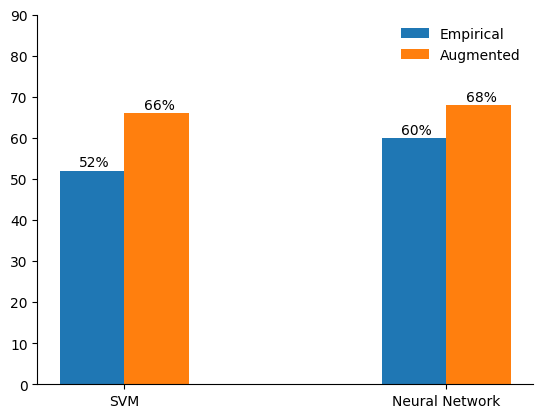

In [ ]:
ax = plt.subplot(111)
plt.bar([.9,1.9],[predictionScores_SVM[0],predictionScores_NN[0]], width=.2)
plt.bar([1.1,2.1],[predictionScores_SVM[1],predictionScores_NN[1]], width=.2)
plt.ylim([0,round((np.max([predictionScores_SVM,predictionScores_NN])+20)/10)*10])
predictionScores = predictionScores_SVM+predictionScores_NN
for xi, x in enumerate([.86,1.06,1.86,2.06]):
    plt.text(x,predictionScores[xi]+1,str(predictionScores[xi])+'%')
plt.xticks([1,2], labels = ['SVM', 'Neural Network'])
plt.legend(['Empirical','Augmented'], loc='upper right', frameon=False)
ax.spines[['right', 'top']].set_visible(False)